### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import ablation, datasets, decomp, prompt_data, utils, vocab

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("attrib"),
        utils.get_style("1col"),
    ]
)
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load model

In [3]:
# pick model to run on
model_name = "meta-llama/Llama-2-7b-chat-hf" # or meta-llama/Llama-2-7b-chat-hf or meta-llama/Llama-2-70b-chat-hf

# You will need to login to huggingface first:
#   huggingface-cli login
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    tl_model = utils.get_llama2_7b_chat_tl_model()
    saved_name = "llama2_7b"
    n_devices = 1 
    batch_size = 5
elif model_name == "meta-llama/Llama-2-13b-chat-hf":
    tl_model = utils.get_llama2_13b_chat_tl_model()
    saved_name = "llama2_13b"
    n_devices = 2
    batch_size = 1
elif model_name == "meta-llama/Llama-2-70b-chat-hf":
    tl_model = utils.get_llama2_70b_chat_tl_model()
    saved_name = "llama2_70b"
    n_devices = 2
    batch_size = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [4]:
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

    _, tmp_cache = tl_model.run_with_cache("hi")
    LABELS = np.array(
        decomp.get_all_resid_components(
            tl_model=tl_model, cache=tmp_cache, pos=-1, batch_idx=0
        ).labels
    )
    print(LABELS[:5])

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions
['EMBED' 'L0H0ATN' 'L0H1ATN' 'L0H2ATN' 'L0H3ATN']


### Load dataset

In [5]:
inference_file_name = f"counterfact_inference_{saved_name}.csv"
df_raw = pd.read_csv(utils.get_repo_root() / "data" / inference_file_name)
ablation_file_name = f"counterfact_ablation_{saved_name}.pkl"
df = pd.read_pickle(
    utils.get_repo_root() / "data" / ablation_file_name
)
df.keys()

Index(['case_id', 'pararel_idx', 'relation_id', 'subject', 'target_new_str',
       'target_true_str', 'fact_prefix', 'irrelevant_word', 'prompt_c',
       'prompt_nc0', 'prompt_nc1', 'p_correct_c', 'p_correct_nc0',
       'p_correct_nc1', 'lo_correct_c', 'lo_correct_nc0', 'lo_correct_nc1',
       'log_bf0', 'log_bf1', 'lo_correct_c_nc0', 'lo_correct_c_nc1',
       'lo_correct_nc0_c', 'lo_correct_nc1_c', 'lo_correct_c_nc0_dcum',
       'lo_correct_c_nc1_dcum', 'lo_correct_nc0_c_dcum',
       'lo_correct_nc1_c_dcum', 'lo_correct_c_nc0_cum', 'lo_correct_c_nc1_cum',
       'lo_correct_nc0_c_cum', 'lo_correct_nc1_c_cum'],
      dtype='object')

In [6]:
log_bf_nc_c = np.concatenate(
    [
        np.stack(df.lo_correct_nc0_c) - df.lo_correct_nc0.to_numpy()[:, None],
        np.stack(df.lo_correct_nc1_c) - df.lo_correct_nc1.to_numpy()[:, None],
    ]
)
log_bf_c_nc = np.concatenate(
    [
        np.stack(df.lo_correct_c_nc0) - df.lo_correct_c.to_numpy()[:, None],
        np.stack(df.lo_correct_c_nc1) - df.lo_correct_c.to_numpy()[:, None],
    ]
)
print(log_bf_c_nc.shape, log_bf_nc_c.shape)

COMPONENT_ORDER = np.argsort(log_bf_nc_c.mean(axis=0))
LABELS_ORDERED = LABELS[COMPONENT_ORDER]
ATN_HEAD_LABEL_MASK = np.array([("ATN" in label) for label in LABELS_ORDERED])
print(LABELS_ORDERED[:10])

ATTN_HEAD_LOCS = [
    (int(label.split("H")[0][1:]), int(label.split("H")[1][:-3]))
    for label in LABELS_ORDERED[ATN_HEAD_LABEL_MASK]
]
print(ATTN_HEAD_LOCS[:5])

(5154, 1057) (5154, 1057)
['L18H9ATN' 'L27H29ATN' 'L31MLP' 'L26H9ATN' 'L25H12ATN' 'L25MLP'
 'L19H23ATN' 'L22H20ATN' 'L23H19ATN' 'L28H7ATN']
[(18, 9), (27, 29), (26, 9), (25, 12), (19, 23)]


### Compute attention response

In [9]:
utils.tokenize_to_strs(df.prompt_c[0], tl_model=tl_model)[47]

'France'

In [10]:
def get_forbidden_token_range(
    prompt: str, forbidden_word: str
) -> tuple[int, int]:
    tokens = tl_model.to_tokens(prompt)[0]
    start = 47
    for end in range(start + 1, len(tokens) + 1):
        if tl_model.to_string(tokens[start:end]) == forbidden_word:
            return (start, end)
    raise ValueError("forbidden word not found")

metrics = []
pbar = tqdm(range(0, len(df), batch_size))
for idx_start in pbar:
    idx_end = min(idx_start + batch_size, len(df))

    prompts: list[str] = []
    forb_words: list[str] = []
    for idx in range(idx_start, idx_end):
        prompts.extend(
            [
                df.prompt_c[idx],
                df.prompt_nc0[idx],
                df.prompt_nc1[idx],
            ]
        )
        forb_words.extend(
            [
                df.target_true_str[idx],
                df.target_new_str[idx],
                df.irrelevant_word[idx],
            ]
        )

    with torch.no_grad():
        _, cache = tl_model.run_with_cache(prompts)

        forb_attns = torch.zeros(
            (len(prompts), tl_model.cfg.n_layers, tl_model.cfg.n_heads)
        )
        for i in range(len(prompts)):
            fstart, fend = get_forbidden_token_range(prompts[i], forb_words[i])
            prompt_len = len(tl_model.to_tokens(prompts[i])[0])
            for layer_num in range(tl_model.cfg.n_layers):
                forb_attns[i, layer_num, :] = cache["pattern", layer_num][
                    i, :, prompt_len - 1, fstart:fend
                ].sum(dim=-1)

    for i in range(idx_end - idx_start):
        metrics.append(
            dict(forb_attn=forb_attns[3 * i : 3 * i + 3].cpu().numpy())
        )

df = df.assign(**pd.DataFrame(metrics))

  0%|          | 0/516 [00:00<?, ?it/s]

### Compute OV response

In [11]:
fas = np.stack(df.forb_attn)
log10odds_fas = torch.tensor(fas).logit().cpu().numpy()
fas.shape

(2577, 3, 32, 32)

In [12]:
def get_ov_resp_matrix(layer: int, head: int):
    """Returns a matrix in units of log_e-prob."""
    W_O = tl_model.W_O[layer, head]
    W_V = tl_model.W_V[layer, head]

    with torch.no_grad():
        raw_logits = utils.unembed(
            tl_model.blocks[layer].ln1(tl_model.W_E) @ W_V @ W_O,
            tl_model=tl_model,
        ).double()

        logits = utils.logit_softmax(raw_logits)

        return logits


def plot_ov_resp_matrix(
    layer: int,
    head: int,
    top_tokens: int = 3,
    largest: bool = False,
):
    d = tl_model.cfg.d_vocab
    log10_resp_mat = get_ov_resp_matrix(layer=layer, head=head) / np.log(10)
    log10_resp_diag = log10_resp_mat.diag()

    top_tokens = torch.topk(
        log10_resp_diag, top_tokens, largest=largest
    ).indices

    suppression_score = (
        (log10_resp_diag.mean() - log10_resp_mat.mean()).item() * d / (d - 1)
    )
    get_sgn = lambda x: "+" if x > 0 else ""
    get_tok_score = lambda tok: log10_resp_diag[tok.item()]
    plt.text(
        0.5,
        0.9,
        "\n".join(
            [
                "OV Suppression",
                f"Dist., Mean: {get_sgn(suppression_score)}${suppression_score:.1f}$",
            ]
        ),
        horizontalalignment="center",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.text(
        0.5,
        -0.35,
        "\n".join(
            [
                f"{tl_model.to_string(tok.item())}: {get_sgn(get_tok_score(tok))}${get_tok_score(tok):.3f}$"
                for tok in top_tokens
            ]
        ),
        horizontalalignment="center",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    utils.plot_hist_from_tensor(
        xs=(log10_resp_diag - log10_resp_mat).flatten(),
        anti_xs=torch.zeros_like(log10_resp_diag),
        bins=500,
        density=True,
        alpha=0.5,
        label="Off-diagonal",
        color="tab:orange",
    )

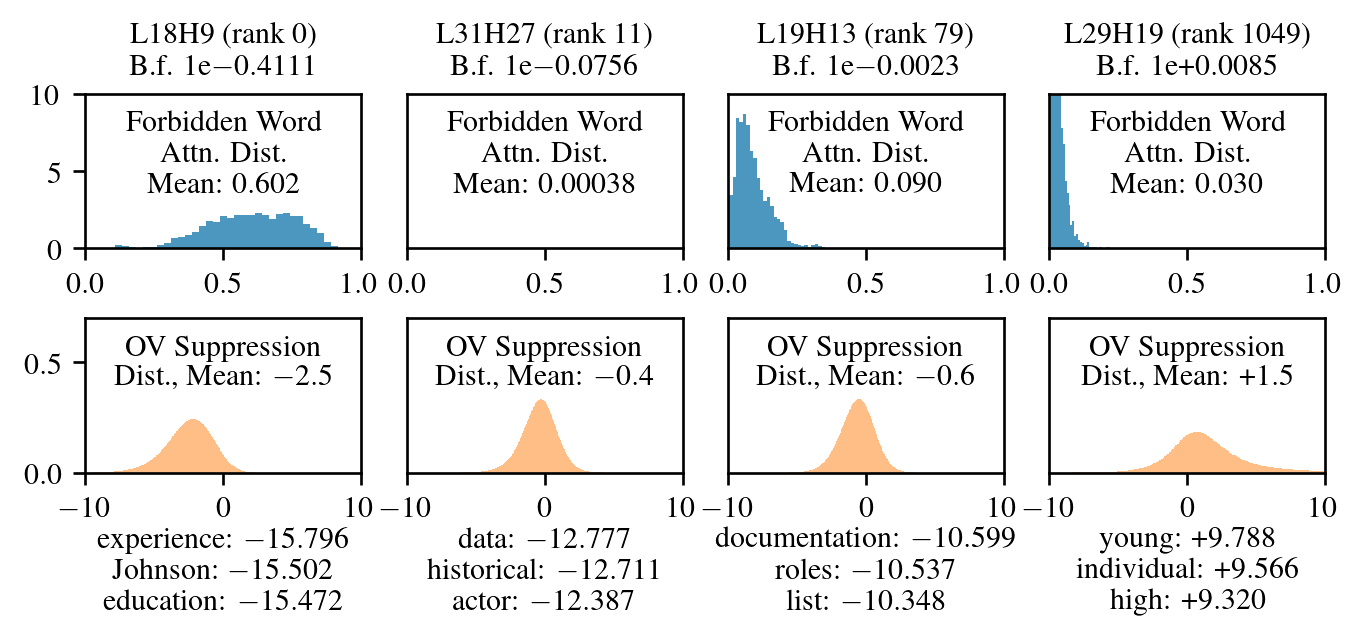

In [13]:
# PLOT_HEADS = [(18, 9, False), (25, 12, False), (28, 7, False), (14, 5, False), (29, 19, True)]
# PLOT_HEADS = [(18, 9, False), (25, 12, False), (28, 7, False), (29, 19, True)]
PLOT_HEADS = [(18, 9, False), (31, 27, False), (19, 13, False), (29, 19, True)]
# PLOT_HEADS = [(33, 11, False), (34, 6, False), (39, 23, False), (32, 5, True)]
fig, _ = plt.subplots(2, 4, height_ratios=[1, 1])
plt.rcParams["ytick.right"] = False

get_sgn = lambda x: "+" if x > 0 else ""
for i, (layer, head, _) in enumerate(PLOT_HEADS):
    plt.subplot(2, 4, i + 1)
    log10_bf = log_bf_nc_c.mean(axis=0)[
        list(LABELS).index(f"L{layer}H{head}ATN")
    ] / np.log(10)
    rank = LABELS_ORDERED.tolist().index(f"L{layer}H{head}ATN")
    plt.title(
        f"L{layer}H{head} (rank {rank})\nB.f. 1e{get_sgn(log10_bf)}${{{log10_bf:.4f}}}$",
        fontsize=9,
    )

    plt.hist(
        # log10odds_fas[:, 0, layer, head],
        fas[:, 0, layer, head],
        density=True,
        bins=32,
        alpha=0.7,
    )
    plt.xlim(0, 1)
    plt.ylim(0, 10)

    plt.text(
        0.5,
        0.9,
        "\n".join(
            [
                "Forbidden Word",
                "Attn. Dist.",
                f"Mean: ${fas[:, 0, layer, head].mean():.3f}$"
                if i != 1
                else f"Mean: ${fas[:, 0, layer, head].mean():.5f}$",
            ]
        ),
        horizontalalignment="center",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.gca().yaxis.set_ticks_position("left")
    if i > 0:
        # Turn off y-axis labels
        plt.yticks([])


for i, (layer, head, largest) in enumerate(PLOT_HEADS):
    plt.subplot(2, 4, 4 + i + 1)
    plot_ov_resp_matrix(
        layer=layer,
        head=head,
        top_tokens=3,
        largest=largest,
    )
    plt.gca().yaxis.set_ticks_position("left")
    if i > 0:
        # Turn off y-axis labels
        plt.yticks([])
    plt.xlim(-10, 10)
    plt.ylim(0, 0.7)

fig.set_figheight(fig.get_figheight() * 0.85)
fig.get_layout_engine().set(wspace=0, w_pad=0)
fig.show()
plt.savefig("./plots/examples-of-heads.pdf", backend="pgf")

In [14]:
for rnk, (layer, head) in enumerate(ATTN_HEAD_LOCS):
    mean = fas[:, 0, layer, head].mean()
    if mean > 0.08:
        print(mean, layer, head, rnk)

0.60184216 18 9 0
0.25406992 27 29 1
0.2578204 26 9 2
0.16767693 25 12 3
0.16439769 19 23 4
0.3267161 22 20 5
0.230266 23 19 6
0.20304689 22 29 10
0.20077324 21 24 11
0.08859327 25 23 14
0.18340549 16 18 17
0.105338104 28 21 18
0.11650522 15 10 19
0.08859552 31 3 20
0.09309223 21 23 22
0.09880659 26 28 24
0.090331614 19 13 67
0.0994054 16 29 78
0.08460515 13 23 955
0.09631478 16 2 988
0.13509235 19 1 999
0.099770226 18 1 1014
0.09442871 22 17 1022


In [15]:
metrics = []
for layer, head in tqdm(ATTN_HEAD_LOCS):
    d = tl_model.cfg.d_vocab

    log10_resp_mat = get_ov_resp_matrix(layer=layer, head=head) / np.log(10)
    log10_resp_diag = log10_resp_mat.diag()
    suppression_score = (
        (log10_resp_diag.mean() - log10_resp_mat.mean()).item() * d / (d - 1)
    )

    metrics.append(
        {
            "layer": layer,
            "head": head,
            "suppression_score": suppression_score,
        }
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
dfm = pd.DataFrame(metrics)

In [ ]:
print("Suppresion score")
print("mean (top 10)", dfm.suppression_score[:10].mean())
print("mean (other):", dfm.suppression_score[10:].mean())
print("std (other):", dfm.suppression_score[10:].std())

Suppresion score
mean (top 10) -1.2209208095619082
mean (other): 0.11800632474720489
std (other): 0.40175600017949964


In [ ]:
for top in [10, 30]:
    print("Suppresion score")
    print(f"mean (top {top})", dfm.suppression_score[:top].mean())
    print(f"std (top {top})", dfm.suppression_score[:top].std())
    print(f"mean (other):", dfm.suppression_score[top:].mean())
    print(f"std (other):", dfm.suppression_score[top:].std())

Suppresion score
mean (top 10) -1.2209208095619082
std (top 10) 0.7966797800798135
mean (other): 0.11800632474720489
std (other): 0.40175600017949964
Suppresion score
mean (top 30) -0.580571740121893
std (top 30) 1.0009307498381654
mean (other): 0.125620077868917
std (other): 0.3800060468989583
